# Web scraping project - Scraping notebook
### **Léo RINGEISSEN & Santiago MARTIN - DIA 3**

## Web scraping page example

For the web scraping part, we decided to scrape user reviews on Tripadvisor. We chose the city of Marseille for our first test.
We used the selenium-enabled chrome webdriver for this task.

The results are then extracted into a csv file. The first tests are conclusive, with just a few formatting issues left to resolve for the date, and some symbols appearing.

Netx objective will be to find a way to extract more reviews at once, since they are displayed five by five. 

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re



# Mettre à jour le chemin vers votre ChromeDriver
driver_path = 'C:/ChromeDriver/chromedriver-win64/chromedriver.exe'

# Configuration du Service WebDriver
service = Service(driver_path)
driver = webdriver.Chrome(service=service)

# URL de la page TripAdvisor
url = 'https://www.tripadvisor.fr/ShowUserReviews-g188113-r110402149-Zurich.html'

# En-têtes pour imiter un navigateur
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:104.0) Gecko/20100101 Firefox/104.0',
    'Accept-Language': 'fr-FR,fr;q=0.9',
    'Referer': 'https://www.google.com',
    'Connection': 'keep-alive'
}

# Def pour transformer la note sur 5
def convert_bubble_to_rating(bubble_class):
    # Extraire le nombre de la classe bubble_XX
    if 'bubble_' in bubble_class:
        bubble_value = int(bubble_class.split('_')[1])
        # Convertir en note sur 5
        print(bubble_value)
        return bubble_value // 10  # Ex: bubble_50 -> 5, bubble_40 -> 4
    return None

# Récupérer la page
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Parser le contenu HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extraire les reviews en fonction de l'id
    review_blocks = soup.find_all('div', id=re.compile(r'review_\d+'))

    reviews = []

    for block in review_blocks:
        # Extraire le titre
        title = block.find('div', class_='quote').get_text(strip=True) if block.find('div', class_='quote') else None
        
        # Extraire le contenu dans la div avec class 'entry'
        content = block.find('div', class_='entry').get_text(strip=True) if block.find('div', class_='entry') else None
        
        # Extraire la note
        rating_element = block.find('span', class_='ui_bubble_rating')
        
        # Transformer la note
        rating = convert_bubble_to_rating(rating_element['class'][1]) if rating_element else None

        # Ajouter la review à la liste
        reviews.append({
            'Title': title,
            'Content': content,
            'Rating': rating,
        })

    # Sauvegarder dans un DataFrame et l'exporter vers un CSV
    df = pd.DataFrame(reviews)
    df.to_csv('tripadvisor_reviews.csv', index=False,sep=';')
    print("Extraction terminée ! Données sauvegardées dans 'tripadvisor_reviews.csv'.")
else:
    print(f"Échec de la récupération de la page. Code de statut : {response.status_code}")


50
Extraction terminée ! Données sauvegardées dans 'tripadvisor_reviews.csv'.


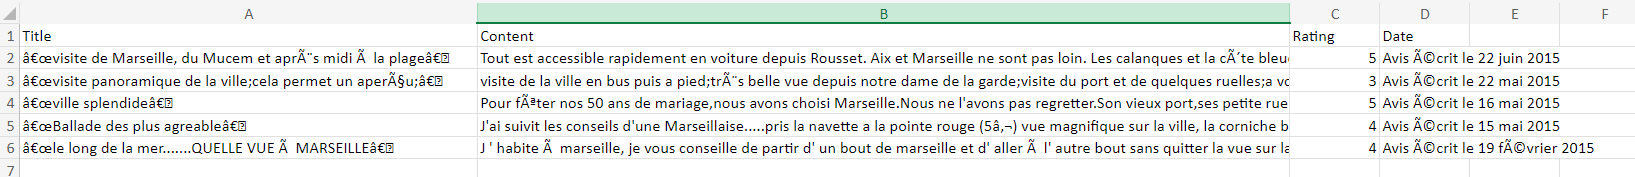


In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
import random

# Mettre à jour le chemin vers votre ChromeDriver
driver_path = 'C:/ChromeDriver/chromedriver-win64/chromedriver.exe'
service = Service(driver_path)
driver = webdriver.Chrome(service=service)

# Fonction pour convertir la note (bubble) en note sur 5
def convert_bubble_to_rating(bubble_class):
    if 'bubble_' in bubble_class:
        bubble_value = int(bubble_class.split('_')[1])
        return bubble_value // 10  # Convertir Ex: bubble_50 -> 5, bubble_40 -> 4
    return None

# Charger le fichier CSV contenant les liens
input_csv = 'filtered_emissions_with_links.csv'
data = pd.read_csv(input_csv, sep=',')

# Liste pour stocker tous les avis collectés
all_reviews = []

# Boucler sur chaque ligne du fichier CSV
for index, row in data.iterrows():
    origine = row['origine']
    destination = row['destination']
    
    # Traiter les colonnes `page1_link` et `page2_link`
    for page_link in ['page1_link', 'page2_link']:
        url = row.get(page_link)
        if pd.isna(url):  # Ignorer si le lien est vide
            continue

        # Attendre un délai aléatoire avant de charger le lien
        time.sleep(random.uniform(3, 7))  # Pause entre 3 et 7 secondes

        # Récupérer la page via requests
        response = requests.get(url, headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:104.0) Gecko/20100101 Firefox/104.0',
            'Accept-Language': 'fr-FR,fr;q=0.9',
            'Referer': 'https://www.google.com',
            'Connection': 'keep-alive'
        })

        if response.status_code == 200:
            # Parser le contenu HTML
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extraire les blocs d'avis
            review_blocks = soup.find_all('div', id=re.compile(r'review_\d+'))

            for block in review_blocks:
                # Extraire le titre
                title = block.find('div', class_='quote').get_text(strip=True) if block.find('div', class_='quote') else None

                # Extraire le contenu
                content = block.find('div', class_='entry').get_text(strip=True) if block.find('div', class_='entry') else None

                # Extraire la note
                rating_element = block.find('span', class_='ui_bubble_rating')
                rating = convert_bubble_to_rating(rating_element['class'][1]) if rating_element else None

                # Ajouter les données collectées à la liste finale
                all_reviews.append({
                    'Origine': origine,
                    'Destination': destination,
                    'Page Link': url,
                    'Title': title,
                    'Content': content,
                    'Rating': rating,
                })
        else:
            print(f"Impossible de récupérer la page : {url}. Code de statut {response.status_code}.")

# Fermer le navigateur
driver.quit()

# Sauvegarder les résultats dans un fichier CSV
output_csv = 'tripadvisor_reviews_automated.csv'
reviews_df = pd.DataFrame(all_reviews)
reviews_df.to_csv(output_csv, index=False, sep=';')
print(f"Extraction terminée ! Données sauvegardées dans '{output_csv}'.")


Extraction terminée ! Données sauvegardées dans 'tripadvisor_reviews_automated.csv'.


In [8]:
import requests

# URL to fetch
url = 'https://www.tripadvisor.fr/ShowUserReviews-g188113-r110402149-Zurich.html'

# Headers for the request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:104.0) Gecko/20100101 Firefox/104.0',
    'Accept-Language': 'fr-FR,fr;q=0.9',
    'Referer': 'https://www.google.com',
    'Connection': 'keep-alive'
}

# Fetch the page content
response = requests.get(url, headers=headers)

if response.status_code == 200:
    # Save the HTML content to a file
    with open('tripadvisor_page.html', 'w', encoding='utf-8') as file:
        file.write(response.text)
    print("Page HTML sauvegardée dans 'tripadvisor_page.html'.")
else:
    print(f"Échec de la récupération de la page. Code de statut : {response.status_code}")


Page HTML sauvegardée dans 'tripadvisor_page.html'.


In [11]:
print(soup)

<!DOCTYPE html>

<html lang="fr-FR" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
<head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<link data-rup="long_lived_global_legacy" href="https://static.tacdn.com/css2/build/concat/long_lived_global_legacy-v21372103084a.css" rel="stylesheet" type="text/css"/>
<link href="https://static.tacdn.com/favicon.ico?v2" id="favicon" rel="icon" type="image/x-icon"/>
<link as="font" crossorigin="" href="https://static.tacdn.com/css2/webfonts/TripAdvisor/TripAdvisor_Regular.woff2?v004.023" rel="preload" type="font/woff2"/>
<link crossorigin="" href="https://static.tacdn.com/css2/webfonts/TripSans/TripSans.css?v1.002" rel="stylesheet"/>
<link color="#000000" href="https://static.tacdn.com/img2/brand_refresh/application_icons/mask-icon.svg" rel="mask-icon" sizes="any">
<script data-rup="global_error" type="text/javascript">!function(){function e(e){return"object"==typeof e&&"WARN"===e.